L1 error = 1.953124701976779e-05


Text(0, 0.5, 'q')

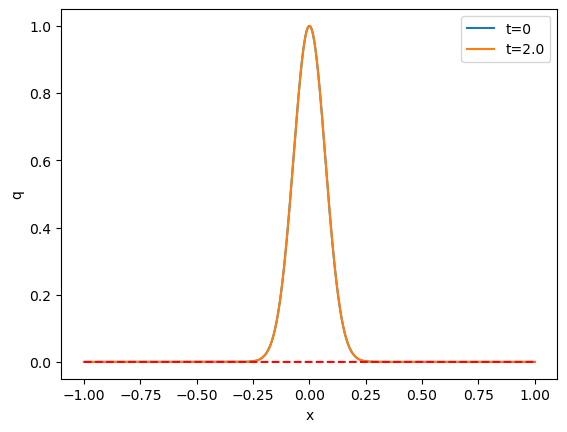

In [ ]:
# RK method 
import numpy as np
import matplotlib.pyplot as plt
from numba import njit


x_min, x_max, nx = -1,1,25600
dx = (x_max-x_min) / (nx)
x0 = 0.0
ng= 2  # = accuracy dimension order 
N = nx + 2*ng


v = 1.0
Time_set = 2.0
lam= 0.25
sig = 0.1
dt = lam*(dx/v)
A = 1.0


qL = np.zeros(N)
qR = np.zeros(N) 
f_half = np.zeros(N+1) 
x = np.zeros(N)

Time = 0.0


for i in range(N):
    x[i] = x_min + (i-ng+0.5)*dx   # x값들은 항상 cell center에 오게끔, 즉 평균 q[i] 값의 위치 = x[i]

q = A * np.exp(-(x-x0)**2/sig**2)
q0 = q.copy()
# jit (Just-In-Time)

@njit  # nopython mode (LLVM code -> Python code 를 읽고 Fortran/C )
def riemann_function(qL,qR,v):     #But, interface flux value 를 모름 -> 이를 구하기 위해 Riemann solver 사용용
    fL = qL * v 
    fR = qR * v 
    return 0.5 * ((fL + fR)-abs(v)*(qR-qL))

@njit
def minmod(a,b):
    sign_a = np.sign(a) # -1 , 0 , 1 
    sign_b = np.sign(b) 
    return 0.5 * (sign_a +sign_b)*min(abs(a),abs(b))  # ab <= 0 -> s_i = 0 , ab>0, a>b => s_i = b , a < b => s_i = a 

@njit
def periodic(q,nx,ng):
    q[:ng] = q[nx:nx+ng] # Periodic 
    q[nx+ng:] = q[ng:ng+ng] # Periodic
    # q[:ng] = q[ng] # ongoing
    # q[nx+ng:] = q[ng+nx-1] # ongoing

    return q

# N = nx + 2*ng
@njit
def RK_method(N,q,nx,ng,x,dx,v,qL,qR,f_half,dqdt):

    q = periodic(q,nx,ng)

    for i in range(ng-1,N-ng+1):
        # print(i)
        sL = (q[i] - q[i-1]) /(x[i]-x[i-1]) 
        sR = (q[i+1] - q[i]) /(x[i+1]-x[i]) 
        sC = (q[i+1] - q[i-1]) /(x[i+1]-x[i-1]) 
        s_i = minmod(sL*2,sR*2)   # limiter 
        s_i = minmod(s_i,sC)    # MC limiter 
        qL[i] = q[i] - s_i*(x[i]-x[i-1])*0.5
        qR[i] = q[i] + s_i*(x[i+1]-x[i])*0.5
        # qL[i] = q[i-1] + s_i*(dx)*0.5 
        # qR[i] = q[i] - s_i*(dx)*0.5 
    # stop 
    for i in range(ng,N-ng+1):
        f_half[i] = riemann_function(qR[i-1], qL[i], v)
        # print(i)


    for i in range(ng,N-ng):
        dqdt[i] = -(f_half[i+1]-f_half[i])/ dx   
    return dqdt

q1 = np.zeros(N)
q2 = np.zeros(N)

# print(len(q1))
while Time < dt:
    if Time + dt > Time_set:   
        dt = Time_set - Time   # For Time == Time_set 
    q_1 = q + dt*RK_method(N,q,nx,ng,x,dx,v,qL,qR,f_half,dqdt)  # 2nd
    q_2 = q_1 + dt*RK_method(N,q_1,nx,ng,x,dx,v,qL,qR,f_half,dqdt) # 2nd
    q = 0.5*(q + q_2) # 2nd 
    # print(q)
    #q_3 = 0.25*(3*q + q_2)  # 3rd
    #q_4 = q_3 + dt*RK_method(q_3,nx,ng,x,dx,v,qL,qR,f_half,dqdt)  # 3rd
    #q = (q+2*q_4) / 3   #3rd


    Time += dt    

    
q_exact = A * np.exp(-(x-x0-v*Time_set)**2/sig**2)

plt.plot(x, q0, label="t=0")
plt.plot(x, q, label=f"t={Time_set}")
plt.plot(x,q_exact,'r--')
plt.legend()

L1 = np.sum(np.abs(q0 - q)[ng:ng+nx-1]) / nx   # L1 norm
print(f"L1 error = {L1}")

plt.xlabel("x")
plt.ylabel("q")

# predictor-corrector method
# 1.9531247019768006e-05

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy import linalg

gamma = 1.4


@njit
def MC_RM(a,b,c): # the precise linear MC reconstruction method
    sign_a = np.sign(a) # -1 , 0 , 1 
    sign_b = np.sign(b) 
    sign_c = np.sign(c)
    s_i = 0.5 * (sign_a +sign_b)*min(abs(a),abs(b))
    sign_i = np.sign(s_i)
    s_f = 0.5 * (sign_i +sign_c)*min(abs(s_i),abs(c))
    return   s_f 



@njit
def conserved_variables(rho,v,p):
    n = rho.size 
    U = np.zeros((5,n))
    U[0,:] = rho 
    U[1,:] = rho * v[0] # x 축
    U[2,:] = rho * v[1] # y 축
    U[3,:] = rho * v[2] # y 축
    kinematics = 0.5*rho*(v[0]**2+v[1]**2+v[2]**2)
    U[4,:] = p/(gamma-1) + kinematics  # using ideal gas
    return U

@njit
def primitive_variables(U):
    rho = U[0]
    v_x = U[1]/rho 
    v_y = U[2]/rho 
    v_z = U[3]/rho
    p = (gamma - 1)*(U[4]-0.5*rho*(v_x**2+v_y**2+v_z**2))  # ideal gas 
    return rho, v_x,v_y,v_z,p

@njit
def flux(U):
    rho,v_x,v_y,v_z,p = primitive_variables(U)
    n = rho.size 
    F = np.zeros((5,n))
    F[0,:] = rho*v_x 
    F[1,:] = rho*v_x*v_x + p 
    F[2,:] = rho*v_x*v_y 
    F[3,:]= rho*v_x*v_z 
    E = U[4]
    F[4,:] = v_x*(E+p)
    return F

@njit
def periodic(U,nx,ng):

    U[:,:ng] = U[:,nx:nx+ng] # Periodic 
    U[:,nx+ng:] = U[:,ng:ng+ng] # Periodic
    # q[:ng] = q[ng] # ongoing
    # q[nx+ng:] = q[ng+nx-1] # ongoing
    return U


@njit
def rusanov_flux(UL, UR):
    rhoL, vxL, vyL,vzL, pL = primitive_variables(UL)
    rhoR, vxR, vyR,vzR, pR = primitive_variables(UR)

    aL = np.sqrt(gamma*pL/rhoL)
    aR = np.sqrt(gamma*pR/rhoR)

    smax = max(abs(vxL)+aL, abs(vxR)+aR)
    
    
    FL = flux(UL)
    FR = flux(UR)
    #  0.5* ((FL+FR) - vxL*(UR-UL))
    return 0.5* ((FL+FR) - smax*(UR-UL))





@njit
def PC_Method_U(U,nx,ng,dx,dt):

    U = periodic(U,nx,ng)

    N = nx+2*ng 
    UL = np.zeros((5, N))
    UR = np.zeros((5, N))
    F_half =np.zeros((5, N+1))
    U_new =np.zeros((5, N))

    for i in range(ng-1,N-ng+1):
        rho_i,vx_i,vy_i,vz_i,p_i = primitive_variables(U[:,i])
        
        for k in range(5):
            sL = (U[k,i] - U[k,i-1]) /(dx) 
            sR = (U[k,i+1] - U[k,i]) /(dx) 
            sC = (U[k,i+1] - U[k,i-1]) /(2*dx) 
            
            s_i = MC_RM(sL*2,sR*2,sC) 
            dqdt = -vx_i*s_i 

            UL[k,i] = U[k,i] - s_i*(dx)*0.5 + dt*0.5*(dqdt)
            UR[k,i] = U[k,i] + s_i*(dx)*0.5 + dt*0.5*(dqdt)
    for i in range(ng,N-ng+1):
        F_half[:,i] = rusanov_flux(UR[:,i-1], UL[:,i])
           
    for i in range(ng,N-ng+1):
        U_new[:,i] = U[:,i] - (F_half[:,i+1]-F_half[:,i])/dx * dt

    return U_new


x_min, x_max, nx = -1,1,400
dx = (x_max-x_min) / (nx)
x0 = 0.0
ng= 2 
N = nx + 2*ng

v = 1.0
Time_set = 1.0
lam= 0.5
sig = 0.1
dt = lam*(dx/v)
A = 1.0
Time = 0.0

x = np.zeros(N)

for i in range(N):
    x[i] = x_min + (i-ng+0.5)*dx

rho = A * np.exp(-(x-x0)**2/sig**2)

v = np.array([1.0,3.0,5.0])

p = 1.0

U = conserved_variables(rho,v,p)


while Time < Time_set:
    if Time + dt > Time_set:   
        dt = Time_set - Time   # For Time == Time_set 

    U =  PC_Method_U(U,nx,ng,dx,dt)
   
    Time += dt 


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(float64, Literal[int](0))
 
There are 22 candidate implementations:
[1m      - Of which 22 did not match due to:
      Overload of function 'getitem': File: <numerous>: Line N/A.
        With argument(s): '(float64, int64)':[0m
[1m       No match.[0m
[0m
[0m[1mDuring: typing of intrinsic-call at C:\Users\wlsdl\AppData\Local\Temp\ipykernel_34820\1841536583.py (35)[0m
[0m[1mDuring: typing of static-get-item at C:\Users\wlsdl\AppData\Local\Temp\ipykernel_34820\1841536583.py (35)[0m
[1m
File "..\..\..\AppData\Local\Temp\ipykernel_34820\1841536583.py", line 35:[0m
[1m<source missing, REPL/exec in use?>[0m

[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function primitive_variables at 0x0000018FC019DF80>))[0m
[0m[1mDuring: typing of call at C:\Users\wlsdl\AppData\Local\Temp\ipykernel_34820\1841536583.py (99)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function primitive_variables at 0x0000018FC019DF80>))[0m
[0m[1mDuring: typing of call at C:\Users\wlsdl\AppData\Local\Temp\ipykernel_34820\1841536583.py (99)
[0m
[1m
File "..\..\..\AppData\Local\Temp\ipykernel_34820\1841536583.py", line 99:[0m
[1m<source missing, REPL/exec in use?>[0m


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy import linalg

gamma = 1.4


def MC_RM(a,b,c): # the precise linear MC reconstruction method
    sign_a = np.sign(a) # -1 , 0 , 1 
    sign_b = np.sign(b) 
    sign_c = np.sign(c)
    s_i = 0.5 * (sign_a +sign_b)*min(abs(a),abs(b))
    sign_i = np.sign(s_i)
    s_f = 0.5 * (sign_i +sign_c)*min(abs(s_i),abs(c))
    return   s_f 



def conserved_variables(rho,v,p):
    n = rho.size 
    U = np.zeros((5,n))
    U[0,:] = rho 
    U[1,:] = rho * v[0] # x 축
    U[2,:] = rho * v[1] # y 축
    U[3,:] = rho * v[2] # y 축
    kinematics = 0.5*rho*(v[0]**2+v[1]**2+v[2]**2)
    U[4,:] = p/(gamma-1) + kinematics  # using ideal gas
    return U


def primitive_variables(U):
    rho = U[0]
    v_x = U[1]/rho 
    v_y = U[2]/rho 
    v_z = U[3]/rho
    p = (gamma - 1)*(U[4]-0.5*rho*(v_x**2+v_y**2+v_z**2))  # ideal gas 
    return rho, v_x,v_y,v_z,p

def flux(U):
    if U.ndim == 1:
        rho,v_x,v_y,v_z,p = primitive_variables(U)
        F = np.zeros(5)
        F[0] = rho*v_x 
        F[1] = rho*v_x*v_x + p 
        F[2] = rho*v_x*v_y 
        F[3] = rho*v_x*v_z 
        E = U[4]
        F[4] = v_x*(E+p)
        return F
    else:
    # 2D 배열인 경우 (사용되지 않을 수 있지만 호환성을 위해 유지)
        n = U.shape[1]
        F = np.zeros((5,n))
        for i in range(n):
            rho,v_x,v_y,v_z,p = primitive_variables(U[:,i])
            F[0,i] = rho*v_x 
            F[1,i] = rho*v_x*v_x + p 
            F[2,i] = rho*v_x*v_y 
            F[3,i] = rho*v_x*v_z 
            E = U[4,i]
            F[4,i] = v_x*(E+p)
        return F
    # rho,v_x,v_y,v_z,p = primitive_variables(U)
    # n = rho.size 
    # F = np.zeros((5,n))
    # F[0,:] = rho*v_x 
    # F[1,:] = rho*v_x*v_x + p 
    # F[2,:] = rho*v_x*v_y 
    # F[3,:]= rho*v_x*v_z 
    # E = U[4]
    # F[4,:] = v_x*(E+p)
    # return F


def periodic(U,nx,ng):

    U[:,:ng] = U[:,nx:nx+ng] # Periodic 
    U[:,nx+ng:] = U[:,ng:ng+ng] # Periodic
    # q[:ng] = q[ng] # ongoing
    # q[nx+ng:] = q[ng+nx-1] # ongoing
    return U



def riemann_flux(UL, UR, vx):

    n = UL.size
    FL = flux(UL)
    FR = flux(UR)
    UL = UL.reshape(n,1)
    UR = UR.reshape(n,1)
    return 0.5* ((FL+FR) - vx*(UR-UL))






def PC_Method_U(U,nx,ng,dx,dt):

    U = periodic(U,nx,ng)

    N = nx+2*ng 
    UL = np.zeros((5, N))
    UR = np.zeros((5, N))
    F_half =np.zeros((5, N+1))
    U_new =np.zeros((5, N))

    for i in range(ng-1,N-ng+1):
        rho_i,vx_i,vy_i,vz_i,p_i = primitive_variables(U[:,i])
        
        for k in range(5):
            sL = (U[k,i] - U[k,i-1]) /(dx) 
            sR = (U[k,i+1] - U[k,i]) /(dx) 
            sC = (U[k,i+1] - U[k,i-1]) /(2*dx) 
            
            s_i = MC_RM(sL*2,sR*2,sC) 
            dqdt = -vx_i*s_i 

            UL[k,i] = U[k,i] - s_i*(dx)*0.5 + dt*0.5*(dqdt)
            UR[k,i] = U[k,i] + s_i*(dx)*0.5 + dt*0.5*(dqdt)
    for i in range(ng,N-ng+1):
        F_half[:,i] = rusanov_flux(UR[:,i-1], UL[:,i])
           
    for i in range(ng,N-ng+1):
        U_new[:,i] = U[:,i] - (F_half[:,i+1]-F_half[:,i])/dx * dt

    return U_new


x_min, x_max, nx = -1,1,400
dx = (x_max-x_min) / (nx)
x0 = 0.0
ng= 2 
N = nx + 2*ng

v = 1.0
Time_set = 1.0
lam= 0.5
sig = 0.1
dt = lam*(dx/v)
A = 1.0
Time = 0.0

x = np.zeros(N)

for i in range(N):
    x[i] = x_min + (i-ng+0.5)*dx

rho = A * np.exp(-(x-x0)**2/sig**2)

v = np.array([1.0,3.0,5.0])

p = 1.0

U = conserved_variables(rho,v,p)


while Time < Time_set:
    if Time + dt > Time_set:   
        dt = Time_set - Time   # For Time == Time_set 

    U =  PC_Method_U(U,nx,ng,dx,dt)
   
    Time += dt 


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


C:\Users\wlsdl\AppData\Local\Temp\ipykernel_34820\437565566.py:37: RuntimeWarning: overflow encountered in scalar power
  p = (gamma - 1)*(U[4]-0.5*rho*(v_x**2+v_y**2+v_z**2))  # ideal gas
C:\Users\wlsdl\AppData\Local\Temp\ipykernel_34820\437565566.py:45: RuntimeWarning: overflow encountered in scalar multiply
  F[1] = rho*v_x*v_x + p
C:\Users\wlsdl\AppData\Local\Temp\ipykernel_34820\437565566.py:45: RuntimeWarning: invalid value encountered in scalar add
  F[1] = rho*v_x*v_x + p
C:\Users\wlsdl\AppData\Local\Temp\ipykernel_34820\437565566.py:102: RuntimeWarning: overflow encountered in multiply
  return 0.5* ((FL+FR) - vxL*(UR-UL))
C:\Users\wlsdl\AppData\Local\Temp\ipykernel_34820\437565566.py:102: RuntimeWarning: invalid value encountered in subtract
  return 0.5* ((FL+FR) - vxL*(UR-UL))
C:\Users\wlsdl\AppData\Local\Temp\ipykernel_34820\437565566.py:128: RuntimeWarning: overflow encountered in scalar multiply
  dqdt = -vx_i*s_i
C:\Users\wlsdl\AppData\Local\Temp\ipykernel_34820\4375655

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
inf
1.969061242368731e-24
-2.979542461476638e+38
-1.668331330205588e+28
-1.5014981971850295e+28
3.645485318976818e+63
343293533102.18866
-5.660991378739848e+19
2151544304.7988467
3898597570.1882668
1.0270272482493588
3.8815312820760873e+28
59967778.9763975
-1.9154372288556132
-167320.48097666132
5147303799.215214
478.7438117752584
756.0500355331042
483.06636709977937
2760.7907282435017
9.474868240434636
1.3068678438290156
0.730535065754

In [30]:
plt.plot(x,)

[ 0.  0. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan na

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit


e = 0 # inner energy 
gamma = 1.5  # ideal gas

@njit
def conserved_variables(rho,v,p):
    U_1 = rho 
    U_2 = rho * v[0] # x 축
    U_3 = rho * v[1] # y 축
    U_4 = rho * v[2] # y 축
    kinematics = 0.5*rho*(v[0]**2+v[1]**2+v[2]**2)
    U_5 = p/(gamma-1) + kinematics 
    return np.array([U_1,U_2,U_3,U_4,U_5])

@njit
def primitive_variables(U):
    rho = U[0]
    v_x = U[1]/rho 
    v_y = U[2]/rho 
    v_z = U[3]/rho
    p = (gamma - 1)*(U[4]-0.5*rho*(v_x**2+v_y**2+v_z**2))  
    return rho, v_x,v_y,v_z,p

@njit
def flux(U):
    rho,v_x,v_y,v_z,p = primitive_variables(U)
    F_1 = rho*v_x 
    F_2 = rho*v_x*v_x + p 
    F_3 = rho*v_x*v_y 
    F_4 = rho*v_x*v_z 
    E = U[4]
    F_5 = v_x*(E+p)
    return np.array([F_1,F_2,F_3,F_4,F_5])


@njit  # nopython mode (LLVM code -> Python code 를 읽고 Fortran/C )
def riemann_function(UL,UR):
    rho_L,vx_L,vy_L,vz_L, pL = primitive_variables(UL)
    rho_R,vx_R,vy_R,vz_R, pR = primitive_variables(UR)


    aL = np.sqrt(gamma*pL/rho_L) # sound velocity
    aR = np.sqrt(gamma*pR/rho_R) # sound velocity

    smax = max(abs(vx_L)+aL,abs(vx_R)+aR)

    FL = flux(UL)
    FR = flux(UR)
    return 0.5 * ((FL + FR)-smax*(UR-UL))

@njit
def MC_RM(a,b,c): # the precise linear MC reconstruction method
    sign_a = np.sign(a) # -1 , 0 , 1 
    sign_b = np.sign(b) 
    sign_c = np.sign(c)
    s_i = 0.5 * (sign_a +sign_b)*min(abs(a),abs(b))
    sign_i = np.sign(s_i)
    s_f = 0.5 * (sign_i +sign_c)*min(abs(s_i),abs(c))
    return   s_f 

@njit
def periodic(U,nx,ng):
    for i in range(len(U)):
        
        U[i][:ng] = U[i][nx:nx+ng] # Periodic 
        U[i][nx+ng:] = U[i][ng:ng+ng] # Periodic
    # q[:ng] = q[ng] # ongoing
    # q[nx+ng:] = q[ng+nx-1] # ongoing

    return U



def PC_Method(N,U,nx,ng,dx,dt,v,qL,qR,f_half,q_new):

    U = periodic(U,nx,ng)
    
    for i in range(ng-1,N-ng+1):
        sL = (q[i] - q[i-1]) /(dx) 
        sR = (q[i+1] - q[i]) /(dx) 
        sC = (q[i+1] - q[i-1]) /(2*dx) 
        # TVD = Total Variation Diminishing - To limit oscillation (overshoot), and retain monotony (Oscillation is caused around discontinuities)
        # TVD - ex. minmod, MC, superbee limiter 
        # TV(q) = np.sum(abs(q[i+1] - q[i])) -> It should follow q_(n+1) < q(n) - TV is not increased comparing next step

        s_i = MC_RM(sL*2,sR*2,sC)    # MC (Monotonized Central limiter) limiter # Stay precise accuaracy, circumvent oscillation
        dqdt = -v*s_i # (dqdx = s_i)
        qL[i] = q[i] - s_i*(dx)*0.5 + dt*0.5*(dqdt)
        qR[i] = q[i] + s_i*(dx)*0.5 + dt*0.5*(dqdt)
    # stop 
    for i in range(ng,N-ng+1):
        f_half[i] = riemann_function(qR[i-1], qL[i], v)
    
    for i in range(ng,N-ng+1):
        q_new[i] = q[i] - (f_half[i+1]-f_half[i])/dx * dt
    
    return q_new



L1 error = 0.17724538509000648


Text(0, 0.5, 'q')

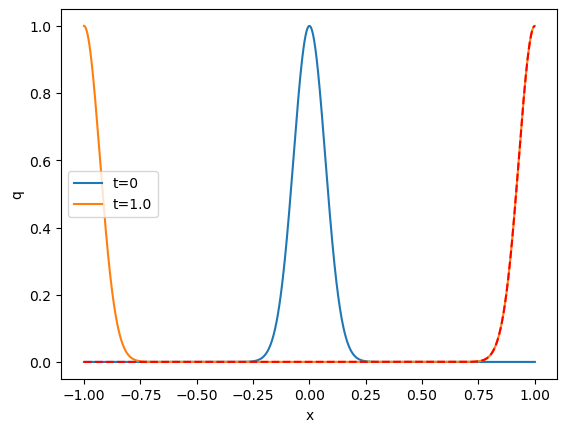

In [2]:
# Predictor-Corrector Method

import numpy as np
import matplotlib.pyplot as plt
from numba import njit


# jit (Just-In-Time)

@njit  # nopython mode (LLVM code -> Python code 를 읽고 Fortran/C )
def riemann_function(qL,qR,v):
    fL = qL * v 
    fR = qR * v 
    return 0.5 * ((fL + fR)-abs(v)*(qR-qL))

@njit
def MC_RM(a,b,c): # the precise linear MC reconstruction method
    sign_a = np.sign(a) # -1 , 0 , 1 
    sign_b = np.sign(b) 
    sign_c = np.sign(c)
    s_i = 0.5 * (sign_a +sign_b)*min(abs(a),abs(b))
    sign_i = np.sign(s_i)
    s_f = 0.5 * (sign_i +sign_c)*min(abs(s_i),abs(c))
    return   s_f 

@njit
def periodic(q,nx,ng):
    q[:ng] = q[nx:nx+ng] # Periodic 
    q[nx+ng:] = q[ng:ng+ng] # Periodic
    # q[:ng] = q[ng] # ongoing
    # q[nx+ng:] = q[ng+nx-1] # ongoing

    return q

# N = nx + 2*ng
@njit
def PC_Method(N,q,nx,ng,dx,dt,v,qL,qR,f_half,q_new):

    q = periodic(q,nx,ng)
    
    for i in range(ng-1,N-ng+1):
        sL = (q[i] - q[i-1]) /(dx) 
        sR = (q[i+1] - q[i]) /(dx) 
        sC = (q[i+1] - q[i-1]) /(2*dx) 
        # TVD = Total Variation Diminishing - To limit oscillation (overshoot), and retain monotony (Oscillation is caused around discontinuities)
        # TVD - ex. minmod, MC, superbee limiter 
        # TV(q) = np.sum(abs(q[i+1] - q[i])) -> It should follow q_(n+1) < q(n) - TV is not increased comparing next step

        s_i = MC_RM(sL*2,sR*2,sC)    # MC (Monotonized Central limiter) limiter # Stay precise accuaracy, circumvent oscillation
        dqdt = -v*s_i # (dqdx = s_i)
        qL[i] = q[i] - s_i*(dx)*0.5 + dt*0.5*(dqdt)
        qR[i] = q[i] + s_i*(dx)*0.5 + dt*0.5*(dqdt)
    # stop 
    for i in range(ng,N-ng+1):
        f_half[i] = riemann_function(qR[i-1], qL[i], v)
    
    for i in range(ng,N-ng+1):
        q_new[i] = q[i] - (f_half[i+1]-f_half[i])/dx * dt
    
    return q_new


x_min, x_max, nx = -1,1,25600
dx = (x_max-x_min) / (nx)
x0 = 0.0
ng= 2 
N = nx + 2*ng

v = 1.0
Time_set = 1.0
lam= 0.5
sig = 0.1
dt = lam*(dx/v)
A = 1.0


qL = np.zeros(N)
qR = np.zeros(N) 
f_half = np.zeros(N+1) 
q_new = np.zeros(N)
Time = 0.0

x = np.zeros(N)

for i in range(N):
    x[i] = x_min + (i-ng+0.5)*dx

q = A * np.exp(-(x-x0)**2/sig**2)
q0 = q.copy()


while Time < Time_set:
    if Time + dt > Time_set:   
        dt = Time_set - Time   # For Time == Time_set 

    q =  PC_Method(N,q,nx,ng,dx,dt,v,qL,qR,f_half,q_new)
   
    Time += dt 



q_exact = A * np.exp(-(x-x0-v*Time_set)**2/sig**2)

plt.plot(x, q0, label="t=0")
plt.plot(x, q, label=f"t={Time_set}")
plt.plot(x,q_exact,'r--')
plt.legend()

L1 = np.sum(np.abs(q0 - q)[ng:ng+nx]) / nx   # L1 norm
print(f"L1 error = {L1}")

plt.xlabel("x")
plt.ylabel("q")

# predictor-corrector method

In [48]:


x_min, x_max, nx = -1,1,200
dx = (x_max-x_min) / (nx)
x0 = 0.0
ng= 2 
N = nx + 2*ng

qL = np.zeros(N)
qR = np.zeros(N) 
f_half = np.zeros(N+1) 
dqdt = np.zeros(N)
dqdx = np.zeros(N)
q_new = np.zeros(N)

x = np.zeros(N)
for i in range(N):
    x[i] = x_min + (i-ng+0.5)*dx

q = A * np.exp(-(x-x0)**2/sig**2)   

time = 0
# for i in range(ng-1,N-ng+1):
#     dqdx[i] = (2*v*(x[i]-x0-v*time)/sig)*q[i] 

for i in range(ng,N-ng+1):
    # print(i)
    sL = (q[i] - q[i-1]) /(x[i]-x[i-1]) 
    sR = (q[i+1] - q[i]) /(x[i+1]-x[i]) 
    sC = (q[i+1] - q[i-1]) /(x[i+1]-x[i-1]) 
    s_i = minmod(sL*2,sR*2)   # limiter 
    s_i = minmod(s_i,sC)    # MC limiter 
    dqdx = (2*v*(x[i]-x0)/sig)*q[i] 
    qL[i] = q[i] - s_i*(dx)*0.5 + dt*0.5*(dqdx)
    qR[i] = q[i] + s_i*(dx)*0.5 + dt*0.5*(dqdx)
    # stop 
for i in range(ng,N-ng+1):
    f_half[i] = riemann_function(qR[i-1], qL[i], v)

for i in range(ng,N-ng+1):
    q_new[i] = q[i] - (f_half[i]-f_half[i-1])/dx *dt

# plt.plot(f_half)
q_new

array([0.00000000e+00, 0.00000000e+00, 1.00869660e-43, 7.30573020e-43,
       5.18657681e-42, 3.60920964e-41, 2.46182691e-40, 1.64595148e-39,
       1.07867511e-38, 6.92912494e-38, 4.36295003e-37, 2.69275100e-36,
       1.62901943e-35, 9.65985130e-35, 5.61472809e-34, 3.19890342e-33,
       1.78643672e-32, 9.77886062e-32, 5.24690240e-31, 2.75950907e-30,
       1.42257370e-29, 7.18839339e-29, 3.56043456e-28, 1.72857524e-27,
       8.22598060e-27, 3.83708291e-26, 1.75440071e-25, 7.86267850e-25,
       3.45403196e-24, 1.48729218e-23, 6.27740789e-23, 2.59703925e-22,
       1.05315135e-21, 4.18617301e-21, 1.63101392e-20, 6.22891313e-20,
       2.33174466e-19, 8.55586290e-19, 3.07723564e-18, 1.08485526e-17,
       3.74884046e-17, 1.26980264e-16, 4.21589324e-16, 1.37200942e-15,
       4.37661850e-15, 1.36846723e-14, 4.19415254e-14, 1.25999305e-13,
       3.71027578e-13, 1.07092324e-12, 3.02987425e-12, 8.40243140e-12,
       2.28401766e-11, 6.08566511e-11, 1.58939101e-10, 4.06881145e-10,
      

In [5]:
x_min, x_max, nx = -1,1,200
dx = (x_max-x_min) / (nx)
x0 = -0.5
ng= 2 
N = nx + 2*ng

# x =  np.arange(x_min-(ng-0.5)*dx,x_max+(ng+0.5)*dx,dx)
x = np.zeros(N)
for i in range(N):
    x[i] = x_min + (i-ng+0.5)*dx
    print(i,x[i])

0 -1.015
1 -1.005
2 -0.995
3 -0.985
4 -0.975
5 -0.965
6 -0.955
7 -0.945
8 -0.935
9 -0.925
10 -0.915
11 -0.905
12 -0.895
13 -0.885
14 -0.875
15 -0.865
16 -0.855
17 -0.845
18 -0.835
19 -0.825
20 -0.815
21 -0.8049999999999999
22 -0.7949999999999999
23 -0.785
24 -0.775
25 -0.765
26 -0.755
27 -0.745
28 -0.735
29 -0.725
30 -0.715
31 -0.7050000000000001
32 -0.6950000000000001
33 -0.685
34 -0.675
35 -0.665
36 -0.655
37 -0.645
38 -0.635
39 -0.625
40 -0.615
41 -0.605
42 -0.595
43 -0.585
44 -0.575
45 -0.565
46 -0.5549999999999999
47 -0.5449999999999999
48 -0.5349999999999999
49 -0.5249999999999999
50 -0.515
51 -0.505
52 -0.495
53 -0.485
54 -0.475
55 -0.46499999999999997
56 -0.45499999999999996
57 -0.44499999999999995
58 -0.43499999999999994
59 -0.42499999999999993
60 -0.41500000000000004
61 -0.405
62 -0.395
63 -0.385
64 -0.375
65 -0.365
66 -0.355
67 -0.345
68 -0.33499999999999996
69 -0.32499999999999996
70 -0.31499999999999995
71 -0.30499999999999994
72 -0.29500000000000004
73 -0.2850000000000000

LLVM : Low Level Virtual Machine 
njit : nopython mode
1. Read Python code
2. Interpret Python code as Machine code (-> translate as Fortran/C language)

404
L_1 =  0.02273502482024342


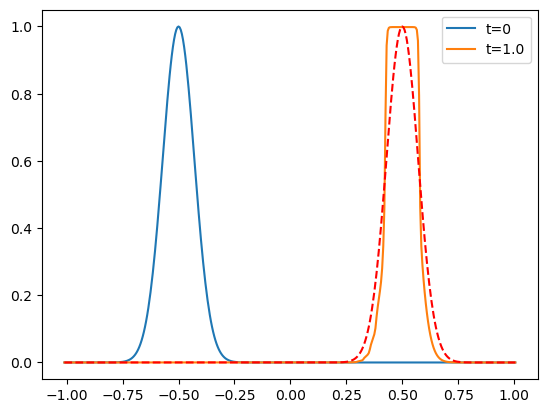

In [4]:
import numpy as np
import matplotlib.pyplot as plt


def riemann_function(qL,qR,v):
    fL = qL * v 
    fR = qR * v 
    return 0.5 * ((fL + fR)-abs(v)*(qR-qL))

def minmod(a,b):
    sign_a = np.sign(a) # -1 , 0 , 1 
    sign_b = np.sign(b) 
    return 0.5 * (sign_a +sign_b)*min(abs(a),abs(b))  # ab <= 0 -> s_i = 0 , ab>0, a>b => s_i = b , a < b => s_i = a 

def periodic(q,nx,ng):
    q[:ng] = q[nx:nx+ng] # Periodic  #ghost cell [0],[1]
    q[-ng:] = q[ng:ng+ng] # Periodic  # ghost cell [ng+nx+ng -2] [ng+nx+ng-1]
    # q[:ng] = q[ng] # ongoing
    # q[nx+ng:] = q[ng+nx-1] # ongoing

    return q


x_min, x_max, nx = -1,1,400
dx = (x_max-x_min) / (nx)
x0 = -0.5
ng=2 
N = nx + 2*ng

qL = np.zeros(N)
qR = np.zeros(N)
f_half = np.zeros(N) 

x =  np.arange(x_min-ng*dx,x_max+ng*dx,dx)  # cell index = nx + ghost cell (2*n-order) 
print(len(x))
# x = np.linspace(x_min-ng*dx,x_max+ng*dx,N)

v = 1.0
Time_set = 1.0
lam= 0.5
sig = 0.1
dt = lam*(dx/v)
A = 1.0

q = A * np.exp(-(x-x0)**2/sig**2)
q0 = q.copy()

Time = 0
counts=0

while Time < Time_set: 
    if Time + dt > Time_set :
        dt = Time_set - Time
    q = periodic(q,nx,ng)
    for i in range(1,N-1):
        sL = (q[i] - q[i-1]) /(x[i]-x[i-1]) 
        sR = (q[i+1] - q[i]) /(x[i+1]-x[i])
        s_i = minmod(sL,sR)
        qL[i] = q[i] - s_i*(x[i]-x[i-1])*0.5
        qR[i] = q[i] + s_i*(x[i+1]-x[i])*0.5
    
    q_new = q.copy()
    for i in range(ng,ng+nx+1):
        f_half[i] = riemann_function(qR[i-1], qL[i], v)
    for i in range(ng,ng+nx):
        q_new[i] = q[i] - (dt/dx) * (f_half[i+1] - f_half[i])
    
    q = q_new 
    Time += dt 
    
q_exact = A * np.exp(-(x-x0-v*Time_set)**2/sig**2)
plt.plot(x, q0, label="t=0")
plt.plot(x, q, label=f"t={Time_set}")
plt.plot(x,q_exact,'r--')
plt.legend()

L_1 = np.sum(abs(q_exact-q)) / N
print("L_1 = ",L_1)